# Proyek Klasifikasi Gambar: Animal Faces
- **Nama:** Syahran Fadhil Dafanindra
- **Email:** fadhilrafa1@gmail.com
- **ID Dicoding:** syahran_fadhil_d

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Input, InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV2

In [2]:
# menonaktifkan warning yang mungkin muncul, seperti warning FutureWarning.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.17.0


## Data Preparation

### Data Loading

In [4]:
# Import module yang disediakan google colab untuk kebutuhan upload file
# untuk kondisi ini, tolong upload api key untuk kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"syahranfd","key":"409642db0c8c619362e51913c5f9eec0"}'}

In [5]:
# Download kaggle dataset
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/animal-faces

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 693M/696M [00:34<00:00, 23.0MB/s]
100% 696M/696M [00:34<00:00, 21.0MB/s]


In [6]:
!unzip animal-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train/wild/fl

In [7]:
# ubah nama directory afhq menjadi animal-faces

!mv afhq animal-faces

In [8]:
# fungsi untuk melihat resolusi gambar
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

print("Data Training")
print_images_resolution("animal-faces/train")
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print("Data Validation")
print_images_resolution("animal-faces/val")

Data Training
wild: 4738
- (512, 512)
---------------
cat: 5153
- (512, 512)
---------------
dog: 4739
- (512, 512)
---------------

Total: 14630

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Data Validation
wild: 500
- (512, 512)
---------------
cat: 500
- (512, 512)
---------------
dog: 500
- (512, 512)
---------------

Total: 1500


In [9]:
# fungsi randomize resolusi gambar
# gambar yang sudah dirandomize akan menimpa file yang sudah ada
def random_resize_images(directory):
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        print(f"{subdir}: {len(image_files)}")
        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                width = random.randint(400, 512)
                height = random.randint(400, 512)
                img = img.resize((width, height))
                img.save(img_path)

print("Data Training")
random_resize_images("animal-faces/train")
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print("Data Validation")
random_resize_images("animal-faces/val")


Data Training
wild: 4738
cat: 5153
dog: 4739

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Data Validation
wild: 500
cat: 500
dog: 500


In [10]:
# melihat kembali resolusi gambar setelah randomize
print("Data Training")
print_images_resolution("animal-faces/train")
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print("Data Validation")
print_images_resolution("animal-faces/val")

Streaming output truncated to the last 5000 lines.
- (441, 496)
- (413, 434)
- (416, 439)
- (489, 429)
- (415, 443)
- (434, 493)
- (492, 434)
- (478, 499)
- (450, 437)
- (510, 488)
- (408, 440)
- (427, 453)
- (471, 496)
- (443, 434)
- (484, 435)
- (429, 499)
- (503, 448)
- (401, 437)
- (464, 493)
- (422, 496)
- (496, 445)
- (482, 510)
- (480, 437)
- (466, 502)
- (499, 450)
- (415, 456)
- (472, 438)
- (491, 451)
- (493, 497)
- (452, 459)
- (512, 510)
- (484, 448)
- (429, 512)
- (487, 453)
- (445, 456)
- (403, 459)
- (477, 408)
- (463, 510)
- (461, 400)
- (447, 502)
- (438, 453)
- (405, 505)
- (498, 467)
- (470, 405)
- (472, 451)
- (431, 413)
- (475, 456)
- (414, 446)
- (433, 459)
- (507, 408)
- (493, 510)
- (452, 472)
- (424, 410)
- (465, 411)
- (468, 453)
- (509, 454)
- (426, 456)
- (467, 457)
- (486, 470)
- (458, 408)
- (442, 400)
- (461, 413)
- (400, 403)
- (460, 454)
- (419, 416)
- (479, 467)
- (418, 457)
- (437, 470)
- (456, 483)
- (495, 411)
- (440, 475)
- (453, 414)
- (497, 457)


In [11]:
# Direktori awal untuk train dan test
train_dir = "animal-faces/train"
test_dir = "animal-faces/val"

# Direktori baru untuk dataset gabungan
combined_dir = "animal-faces/dataset"

In [12]:
# Buat direktori baru untuk dataset gabungan
# exist_ok true agar tidak terjadi error jika directory sudah ada
os.makedirs(combined_dir, exist_ok=True)

In [13]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

### Checking Dataset

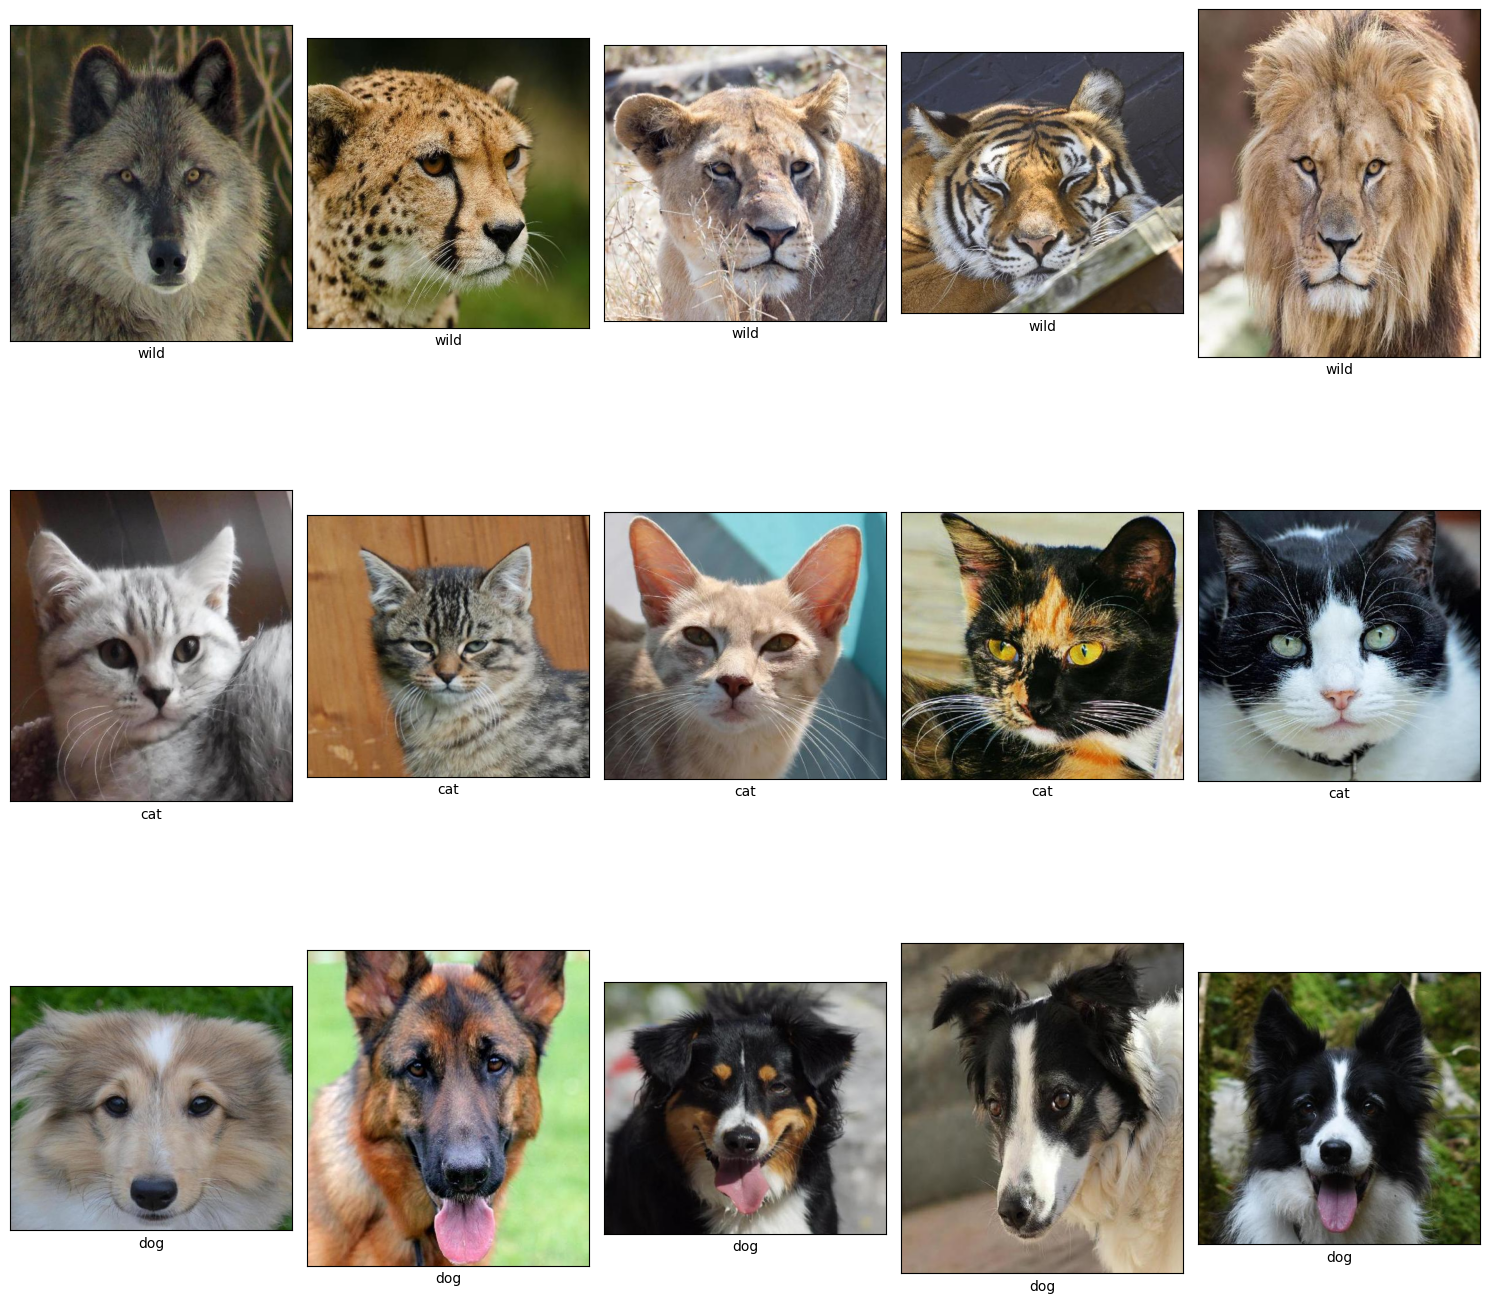

In [14]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
animal_faces_image = {}

# Tentukan path sumber train
path = "animal-faces/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    animal_faces_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "animal-faces/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(animal_faces_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(animal_faces_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

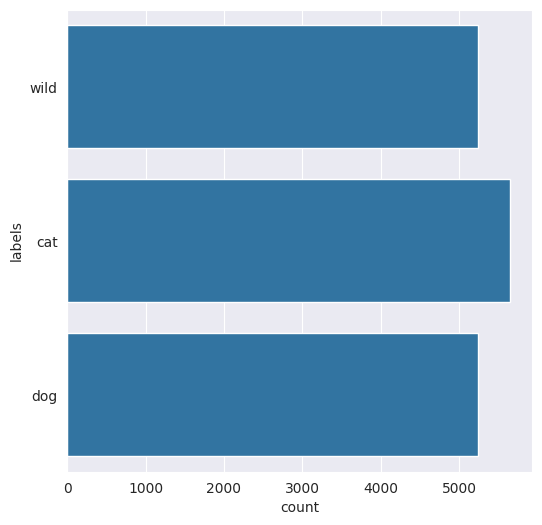

In [15]:
# Definisikan path sumber
animal_faces_path = "animal-faces/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(animal_faces_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# hasil dari diagram terlihat bahwa ketiga label data sudah merata

### Data Preprocessing

#### Split Dataset

In [16]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'animal-faces/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
cat,5653
dog,5239
wild,5238


In [17]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [18]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [19]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "animal-faces/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)


set    labels
test   cat       1177
       dog       1034
       wild      1015
train  cat       4476
       dog       4205
       wild      4223
dtype: int64 


                                                  path labels    set
7538  animal-faces/dataset/wild/flickr_wild_000035.jpg   wild  train
8100    animal-faces/dataset/cat/flickr_cat_000063.jpg    cat  train
7001   animal-faces/dataset/dog/pixabay_dog_002329.jpg    dog  train
2729    animal-faces/dataset/dog/flickr_dog_000191.jpg    dog  train
4713   animal-faces/dataset/dog/pixabay_dog_002889.jpg    dog  train


0it [00:00, ?it/s]

### Image Data Generator
 melakukan augmentasi dan pra-pemrosesan gambar secara otomatis selama pelatihan model.

 - membagi dataset menjadi set pelatihan dan validasi
 - normalisasi gambar dengan menskalakan nilai piksel
 - memasukkan data gambar langsung ke model selama pelatihan, evaluasi, dan prediksi

In [20]:
# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_cat = os.path.join(TRAIN_DIR + '/cat')
train_dog = os.path.join(TRAIN_DIR + '/dog')
train_wild = os.path.join(TRAIN_DIR + '/wild')
test_cat = os.path.join(TEST_DIR + '/cat')
test_dog = os.path.join(TEST_DIR + '/dog')
test_wild = os.path.join(TEST_DIR + '/wild')

print("Total number of cat images in training set: ",len(os.listdir(train_cat)))
print("Total number of dog images in training set: ",len(os.listdir(train_dog)))
print("Total number of wild images in training set: ",len(os.listdir(train_wild)))
print("Total number of cat images in test set: ",len(os.listdir(test_cat)))
print("Total number of dog images in test set: ",len(os.listdir(test_dog)))
print("Total number of wild images in test set: ",len(os.listdir(test_wild)))

Total number of cat images in training set:  4476
Total number of dog images in training set:  4205
Total number of wild images in training set:  4223
Total number of cat images in test set:  1177
Total number of dog images in test set:  1034
Total number of wild images in test set:  1015


In [21]:
# Buat objek ImageDataGenerator yang menormalkan gambar
# Hapus parameter validation_split
datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Gunakan seluruh data training
train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              shuffle=True)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=32,
                                                  target_size=(150,150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 12904 images belonging to 3 classes.
Found 3226 images belonging to 3 classes.


## Modelling

In [22]:
# Memuat model MobileNetV2 yang telah terlatih
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

# Membekukan semua layer dari model yang telah dilatih sebelumnya
pre_trained_model.trainable = False

# Membuat model Sequential dan menambahkan MobileNetV2 sebagai base
model = Sequential()

# Menambahkan pre-trained MobileNetV2
model.add(pre_trained_model)

# Menambahkan lapisan Conv2D dan Pooling tambahan
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Meratakan output dari layer sebelumnya
model.add(Flatten())

# Menambahkan Dropout untuk mencegah overfitting
model.add(Dropout(0.3))

# Menambahkan lapisan Dense fully connected
model.add(Dense(128, activation='relu'))

# Menambahkan lapisan output dengan softmax untuk klasifikasi 3 kategori
model.add(Dense(3, activation='softmax'))

<ipython-input-22-691668e5933b>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:
# Membuat optimizer
int_lr = 1e-4

optimizer = tf.optimizers.Adam(learning_rate=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# Callback untuk menghentikan pelatihan jika akurasi dan akurasi validasi di atas 97%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97 and logs.get('val_accuracy')>0.97):
      print("\nAkurasi dan validation akurasi telah mencapai >97%!")
      self.model.stop_training = True

callbacks = myCallback()

In [25]:
count_cat, count_dog, count_wild = len(os.listdir(train_cat)), len(os.listdir(train_dog)), len(os.listdir(train_wild))
weight_0 = (1 / count_cat) * (count_cat + count_dog + count_wild) / 2.0
weight_1 = (1 / count_dog) * (count_cat + count_dog + count_wild) / 2.0
weight_2 = (1 / count_wild) * (count_cat + count_dog + count_wild) / 2.0

class_weights = {0 : weight_0, 1 : weight_1, 2 : weight_2}

%time

# Fitting / training model
history_1 = model.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=test_generator,
                        callbacks=[callbacks],
                        class_weight = class_weights)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


404/404 ━━━━━━━━━━━━━━━━━━━━ 372s 899ms/step - accuracy: 0.8921 - loss: 0.4423 - val_accuracy: 0.9929 - val_loss: 0.0270
Epoch 2/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9940 - loss: 0.0285
Akurasi dan validation akurasi telah mencapai >97%!
404/404 ━━━━━━━━━━━━━━━━━━━━ 376s 883ms/step - accuracy: 0.9940 - loss: 0.0285 - val_accuracy: 0.9895 - val_loss: 0.0384


## Evaluasi dan Visualisasi

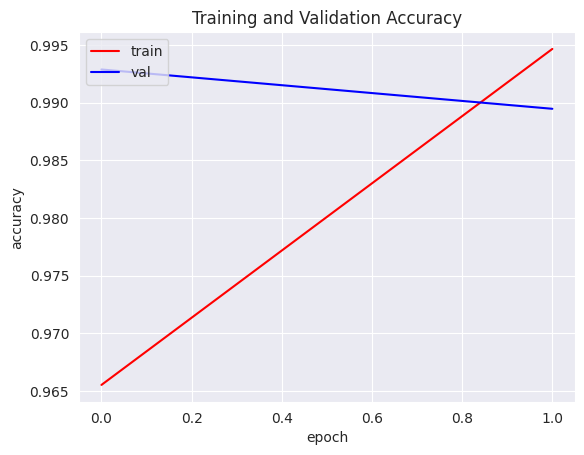

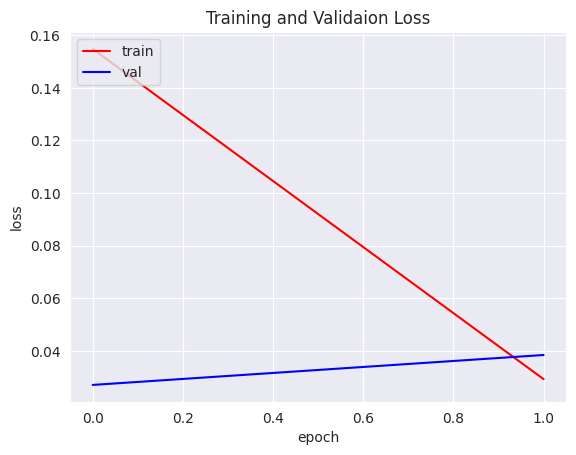

In [26]:
# menampilkan grafik hasil dari pelatihan model
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

### jika tidak muncul garis di grafik, itu dikarenakan saat pelatihan model hanya berjalan sekali / 1 epoch



              precision    recall  f1-score   support

         Cat     0.9932    0.9983    0.9958      1177
         Dog     0.9764    1.0000    0.9881      1034
        Wild     0.9990    0.9685    0.9835      1015

    accuracy                         0.9895      3226
   macro avg     0.9895    0.9889    0.9891      3226
weighted avg     0.9896    0.9895    0.9894      3226



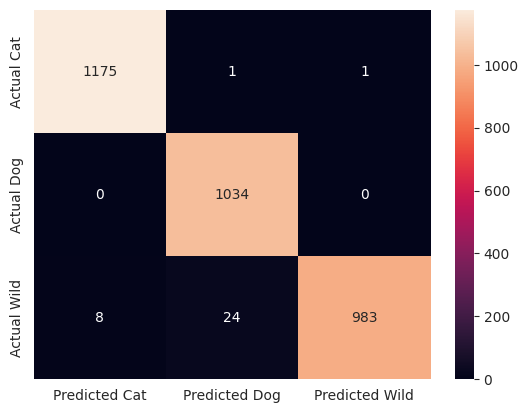

In [27]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Melakukan prediksi menggunakan model yang sudah dilatih
test_generator.reset()  # Mengatur ulang generator untuk menghindari masalah prediksi

preds_1 = model.predict(test_generator, verbose=0)
preds_1 = preds_1.copy()

# Mengambil argmax dari prediksi karena kita memiliki 3 kelas
preds_1 = preds_1.argmax(axis=1)

# Definisikan label sesuai kelas (0: Cat, 1: Dog, 2: Wild)
labels = ['Cat', 'Dog', 'Wild']

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1, 2]),
                  index=["Actual Cat", "Actual Dog", "Actual Wild"],
                  columns=["Predicted Cat", "Predicted Dog", "Predicted Wild"])

# Visualisasikan confusion matrix
sns.heatmap(cm, annot=True, fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes, y_pred=preds_1, target_names=labels, digits=4))


## Konversi Model

In [28]:
# hapus folder saved_model, tfjs_model, tflite, file model.h5, dan model.zip
!rm -rf saved_model tfjs_model tflite model.h5 model.zip

In [29]:
# Konversi Format SavedModel
model.export("saved_model/animal_faces_model/1")

Saved artifact at 'saved_model/animal_faces_model/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133190573333616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190573337136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190573335200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190573334672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190573332736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190573340480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190573340656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190546130192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190573341008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190573338544: TensorSpec(shape=(), dtype=tf.resource, name=No

In [30]:
# Konversi Tensorflow.js

# menyimpan model
model.save("model.h5")

# Install tensorflowjs
!pip install tensorflowjs
# mengubah model.h5 kedalam bentuk json
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 731.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 66.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
2024-09-18 11:43:20.962870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 11:43:20.992601: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 11:43:21.001253: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to r

In [31]:
# Konversi Tensorflow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_model_file = pathlib.Path("model.tflite")
tflite_model_file.write_bytes(tflite_model)

Saved artifact at '/tmp/tmprs12ub4m'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133190573333616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190573337136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190573335200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190573334672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190573332736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190573340480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190573340656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190546130192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190573341008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190573338544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1331905461

10449928

In [32]:
# Definisikan label sesuai kelas (0: Cat, 1: Dog, 2: Wild)
labels = ['Cat', 'Dog', 'Wild']

# Simpan label ke file label.txt
with open('label.txt', 'w') as f:
  for label in labels:
    f.write(label + '\n')


In [33]:
# membuat folder tflite dan memindahkan model.tflite dan label.txt ke dalamnya
!mkdir tflite
!mv model.tflite label.txt tflite/

In [34]:
!pip freeze > requirements.txt

In [35]:
# buat folder dan file yang dibutuhkan menjadi zip agar mudah didownload
!zip -r model.zip saved_model tfjs_model tflite model.h5 requirements.txt

  adding: saved_model/ (stored 0%)
  adding: saved_model/animal_faces_model/ (stored 0%)
  adding: saved_model/animal_faces_model/1/ (stored 0%)
  adding: saved_model/animal_faces_model/1/assets/ (stored 0%)
  adding: saved_model/animal_faces_model/1/variables/ (stored 0%)
  adding: saved_model/animal_faces_model/1/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/animal_faces_model/1/variables/variables.index (deflated 78%)
  adding: saved_model/animal_faces_model/1/fingerprint.pb (stored 0%)
  adding: saved_model/animal_faces_model/1/saved_model.pb (deflated 91%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/model.json (deflated 97%)
  adding: tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard1of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: tflite/ (stored 0%)
  adding: tflite/label.txt (stored 0%)
  adding: tflite/model.tflite (deflated 7%)
  adding: model.h5 (deflated 9%)
  addin

## Inference (Optional)

In [36]:
class_indices = train_generator.class_indices
print(class_indices)

{'cat': 0, 'dog': 1, 'wild': 2}


In [1]:
import tensorflow as tf
import requests

def images_preprocessing(filenames):
    image_tensors = []
    for filename in filenames:
        image = tf.io.decode_image(open(filename, 'rb').read(), channels=3)
        image = tf.image.resize(image, [150, 150])
        image = image / 255.0
        image_tensors.append(image)

    # Convert the list of images into a batch
    image_tensors = tf.stack(image_tensors)
    image_tensors = image_tensors.numpy().tolist()  # Convert to list format for JSON
    return image_tensors

# List of filenames for the images (Cat, Dog, Wild)
filenames = ['images/cat_face.jpg', 'images/dog_face.jpg', 'images/wild_face.jpg']

# Prepare the data (image batch) to be sent in the POST request
image_tensors = images_preprocessing(filenames=filenames)

json_data = {
    "instances": image_tensors
}

# Define the endpoint with format: http://localhost:8501/v1/models/MODEL_NAME:predict
endpoint = "http://localhost:8501/v1/models/animal_faces_model:predict"

response = requests.post(endpoint, json=json_data)

# Process the response
response_json = response.json()
if 'predictions' in response_json:
    map_labels = {0: "Cat", 1: "Dog", 2: "Wild"}

    # Iterate through each prediction and print the result
    for i, prediction in enumerate(response_json['predictions']):
        predicted_label = tf.argmax(prediction).numpy()  # Get the predicted class
        print(f"Prediction for image {filenames[i]}: {map_labels[predicted_label]}")
else:
    print("Error: 'predictions' key not found in the response.")
    print("Response content:", response_json)


Prediction for image images/cat_face.jpg: Cat
Prediction for image images/dog_face.jpg: Dog
Prediction for image images/wild_face.jpg: Wild
